## Fraud Detection Notebook
### Team Members: Bismah Khan and Farooq Husain
### Date: 26 July 2021

| Column Name |                                                                       Description                                                                       |
|:-----------:|:-------------------------------------------------------------------------------------------------------------------------------------------------------:|
|     Step    |                This feature represents the day from the start of simulation. It has 180   steps so simulation ran for virtually 6 months.               |
|   Customer  |                                             This is the unique customer ID which is assigned to a customer.                                             |
|     Age     | These are the age brackets assigned to the relevant customers. 0: <=   18,  1: 19-25, 2: 26-35, 3: 36-45, 4:   46:55, 5: 56:65, 6: > 65 and U: Unknown. |
|    Gender   |                                   Gender of the customer - F -> Female , M -> Male , U -> Unknown,   E -> Enterprise.                                   |
|  zipcodeOri |                                                                Zip code of the customer.                                                                |
|   merchant  |                                               It is the the unique ID attributed to a particular Merchant.                                              |
| zipMerchant |                                                                 Zip code of the merchant                                                                |
|   category  |                                       Line of business of the merchant or the services provided by the   merchant.                                      |
|    amount   |                                                   The amount of transaction performed by the customer                                                   |
|    fraud    |                                             0 indicates genuine transaction, 1 indicates fraudulent activity                                            |

## Goal of the project:

1. Identify the characteristics of fraudulent transactions;
2. Evaluate fraudulent transactions to determine if they follow any predetermined pattern e.g. round-sum transactions, amounts involved in the transactions, sectors most susceptible to fraud etc;
3. Determine if fraudulent transactions were common within a specific age-group, gender or entity;
4. Choose a suitable machine learning model to predict fraudulent transactions based on the identified characteristics accompanying fraudulent transactions;
5. Analyse limitations of the Machine Learning Model.




## EDA

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [138]:
bankFraud = pd.read_csv('./bs140513_032310.csv')

In [139]:
bankFraud.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151',4,M,'28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107',2,M,'28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914',4,F,'28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790',3,M,'28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768',5,M,'28007','M348934600','28007','es_transportation',35.72,0


We noted that the columns titled ***'zipcodeOri'*** and ***'zipMerchant'*** had only one value of ***'28007'***. Since all entries had the same entry in these two columns, we decided to remove these columns since they would not prove useful in our machine learning model.

We also decided to remove the ***"step"*** column since we understand that it is the count of day for the whole simulation and would have little impact on training the machine learning model.

In [140]:
# Removing inverted commas from the relevant columns to assist with mapping later in the data analysis.
bankFraud.loc[:, 'customer']= bankFraud.loc[:,'customer'].str.replace("'","")
bankFraud.loc[:, 'age']= bankFraud.loc[:,'age'].str.replace("'","")
bankFraud.loc[:, 'gender']= bankFraud.loc[:,'gender'].str.replace("'","")
bankFraud.loc[:, 'merchant']= bankFraud.loc[:,'merchant'].str.replace("'","")
bankFraud.loc[:, 'category']= bankFraud.loc[:,'category'].str.replace("'","")

In [141]:
bankFraud.head()
# We can see that the single inverted commas have been removed

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,'28007',M348934600,'28007',es_transportation,4.55,0
1,0,C352968107,2,M,'28007',M348934600,'28007',es_transportation,39.68,0
2,0,C2054744914,4,F,'28007',M1823072687,'28007',es_transportation,26.89,0
3,0,C1760612790,3,M,'28007',M348934600,'28007',es_transportation,17.25,0
4,0,C757503768,5,M,'28007',M348934600,'28007',es_transportation,35.72,0


In [142]:
unwantedFeatures = ['zipcodeOri','zipMerchant','step','customer','merchant']
features = bankFraud.drop(unwantedFeatures, axis=1, inplace=True)

In [143]:
# Counts missing value in the data frame
bankFraud.isnull().sum()

age         0
gender      0
category    0
amount      0
fraud       0
dtype: int64

With this method, we have concluded that there are no missing values

In [144]:
with pd.option_context('display.max_columns', 66):
     print(bankFraud.groupby('fraud').describe(include='all'))

          age                                                        gender  \
        count unique top    freq mean  std  min  25%  50%  75%  max   count   
fraud                                                                         
0      587443      8   2  184966  NaN  NaN  NaN  NaN  NaN  NaN  NaN  587443   
1        7200      8   2    2344  NaN  NaN  NaN  NaN  NaN  NaN  NaN    7200   

                                                            category         \
      unique top    freq mean  std  min  25%  50%  75%  max    count unique   
fraud                                                                         
0          4   F  319807  NaN  NaN  NaN  NaN  NaN  NaN  NaN   587443     15   
1          3   F    4758  NaN  NaN  NaN  NaN  NaN  NaN  NaN     7200     12   

                                                                       amount  \
                     top    freq mean  std  min  25%  50%  75%  max     count   
fraud                                         

### From the describe method, we've learned the following: 

1. **Total Number of Fraudulent Activities***: 7200
2. ***Total Number of Unique Merchants***: 50
3. ***Total Number of Unique Customers Involved in Fraudulent Activities***: 1483 (36.07% of the customers)
4. ***Mean Avg of Genuine Transactions***: Approx 32 dollars
5. ***Mean Avg of Fraudulent Transactions***: Approx 531 dollars
6. ***Max Amount of Single Fraudulent Transaction***: Approx 8330 dollars
7. Customer ***'C1350963410'*** has indulged in 144 fraudulent transactions
8. Least Amount of Non-Fraudulent Transaction: 0 dollars -> These rows can be dropped since they're useless

In [145]:
# Least Amount of Non-Fraudulent Transaction: 0 dollars -> These rows can be dropped since they're useless & outliers
bankFraud.drop(bankFraud.loc[bankFraud['amount']==0].index, inplace=True)

In [146]:
# We've replaced the string 'U' that describes the Unknown values in the age column and assigned it to the key '7'
bankFraud['age'] = bankFraud['age'].replace('U','7')

In [147]:
# We used this method to convert column age which was intially documented as string to an integer to facilitate our analysis.
bankFraud['age'] = bankFraud['age'].apply(pd.to_numeric)
bankFraud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594591 entries, 0 to 594642
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   age       594591 non-null  int64  
 1   gender    594591 non-null  object 
 2   category  594591 non-null  object 
 3   amount    594591 non-null  float64
 4   fraud     594591 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 27.2+ MB


In [148]:
bankFraud.pivot_table('amount', index='gender', columns='fraud', aggfunc='count')

fraud,0,1
gender,,
E,1170.0,7.0
F,319780.0,4758.0
M,265926.0,2435.0
U,515.0,NaN


We have 515 Unknown values for gender and none of these transactions are involved in any fraudulent activities so we've deemed this to be insignificant and have decided to drop it from our data.

In [149]:
for index, row in bankFraud.iterrows():
   if row['gender'] == 'U':
        bankFraud.drop(index, inplace=True)

In [150]:
# Convert 'Gender' to 1,2,3 instead of F,M,E
# .map() will map values in the original to values in the specified data
genderFlag = {
    'F': 1,
    'M': 2,
    'E': 3,
}

bankFraud['gender'] = bankFraud['gender'].map(genderFlag)

In [151]:
bankFraud_fraud = bankFraud.loc[bankFraud.fraud == 1]

Text(0.5, 1.0, 'Group data by Gender')

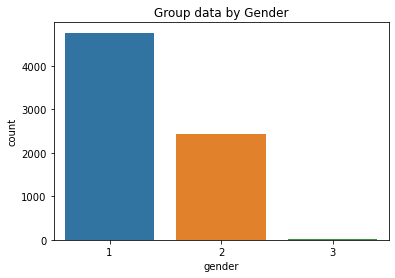

In [152]:
plt.figure()
fig = sns.countplot(x='gender', data=bankFraud_fraud)
plt.title('Group data by Gender')

# Female : 1
# Male : 2
# Enterprise : 3

From the above figure, it can be determined that **females** are involved in double the amount of fraudulent activities than **males**.

In [153]:
bankFraud.pivot_table('amount', index='category', columns='fraud', aggfunc='count')

fraud,0,1
category,,
es_barsandrestaurants,6250.0,120.0
es_contents,885.0,NaN
es_fashion,6332.0,116.0
es_food,26224.0,NaN
es_health,14416.0,1696.0
es_home,1682.0,302.0
es_hotelservices,1196.0,548.0
es_hyper,5816.0,280.0
es_leisure,25.0,474.0


The table above shows that the below categories were not associated with any fraudulent transactions

**1. es_contents**
**2. es_food**
**3. es_transportation**

Two sectors that exhibited the most fraudulent transactions which were **es_sportsandtoys** and **es_health**.

In [154]:
bankFraud = pd.get_dummies(bankFraud, columns=['category'])
bankFraud.head()

,age,gender,amount,fraud,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty
0,4,2,4.55,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2,2,39.68,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,4,1,26.89,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,3,2,17.25,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,5,2,35.72,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [155]:
bankFraud.pivot_table('amount', index='age', columns='fraud', aggfunc='count')
# 0: <= 18 
# 1: 19-25 
# 2: 26-35 
# 3: 36-45
# 4: 46:55
# 5: 56:65
# 6: > 65 
# 7: Unknown ('U' has been changed to 7)

fraud,0,1
age,,
0,2404,48
1,57263,689
2,184781,2344
3,145187,1755
4,107608,1410
5,61952,686
6,26511,261
7,1170,7


We have 1178 "Unknown" values for age out of which 7 of these transactions were engaged in fraudulent activities. Initially this appeared insignificant, but upon further exploring, we determined that all the Unknown values for age were interlinked to the Enterprise values in the gender column.

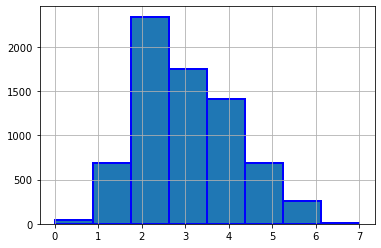

In [156]:
bankFraud_fraud['age'].hist(bins=8, edgecolor='blue', linewidth=2)
# 0: <= 18 
# 1: 19-25 
# 2: 26-35 
# 3: 36-45
# 4: 46:55
# 5: 56:65
# 6: > 65 
# 7: Unknown ('U' has been changed to 7)

From the histogram above, we can determine that fraudulent activities are more common amongst people ranging from the age group of 26-55

In [157]:
#bankFraud_fraud.pivot_table('amount',index='customer', columns='fraud', aggfunc='sum')

## Features

In [158]:
label = bankFraud['fraud']
features = bankFraud.drop('fraud', axis=1)

In [197]:
trainF, testF, trainL, testL = train_test_split(features, label, test_size=0.4, random_state=42)

In [160]:
for dataset in [trainF, testF]:
    ratio = round(len(dataset) / len(features), 2)
    print(ratio)

0.6
0.4


In [161]:
categorical_features_indices = np.where(features.dtypes != np.float)[0]
print(categorical_features_indices)

[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


## Machine Learning Model

Model Chosen: **CatBoost**. We can use CatBoost without any explicit pre-processing to convert categories into numbers. CatBoost converts categorical values into numbers using various statistics on combinations of categorical features and combinations of categorical and numerical features

In [162]:
#!pip3 install catboost

#from sklearn.model_selection import train_test_split
#from catboost import CatBoostRegressor
#from sklearn.metrics import mean_absolute_error

In [163]:
#model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')

In [164]:
#model.fit(trainF, trainL,cat_features=categorical_features_indices,eval_set=(testF, testL),plot=True)

In [165]:
#msae = mean_absolute_error(trainL, model.predict(trainF))
#print(msae)

In [166]:
#msae = mean_absolute_error(testL, model.predict(testF))
#print(msae)

## Alternate ML Model
### Random Forest Classifier

In [167]:
# To train the machine learning model, we first need to one hot-encode the columns for customer and merchant.

#bankFraud = pd.get_dummies(bankFraud, columns=['customer','merchant'])

In [207]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=20)
model.fit(trainF, trainL)

RandomForestClassifier(n_estimators=20)

In [208]:
model.score(testF, testL)

0.9926398491779271

In [200]:
label_predicted = model.predict(testF)

In [203]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testL, label_predicted)
cm

array([[233992,    750],
       [   989,   1900]], dtype=int64)

Text(69.0, 0.5, 'Truth')

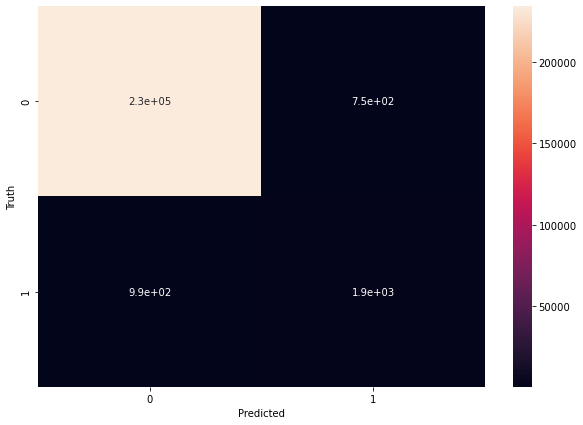

In [206]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')